# NJ Housing 2020 Data Analysis

### Serious Crime Heat Map

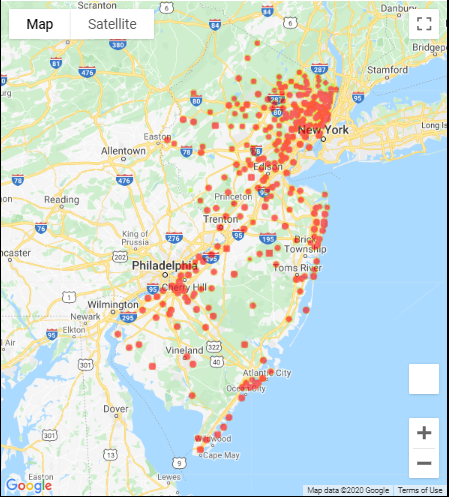

### Best Places to live in NJ
#### Parameters: 
* serious crimes < 150 (per year per 10K people)
* school ranking > 70%
* property tax < 7K
* median house price < 400K
* avg icome > 40K

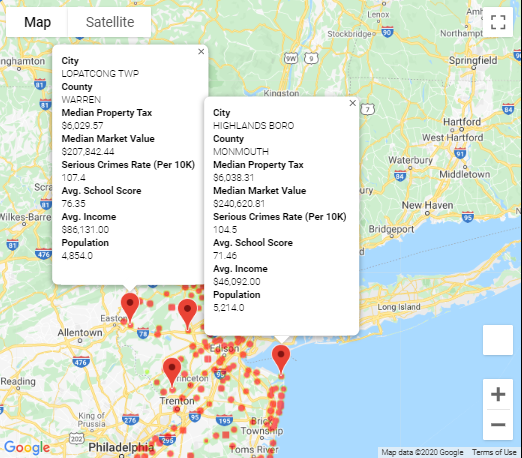

In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import requests
import gmaps
import json

In [9]:
#Define file paths

#County Town Zip 
input_path_County_town_zip=os.path.join("..","Final Output Data","CountyTownZipAnalysis_Data.csv")

#Property tax and House Value
input_path_tax_town=os.path.join("..","Final Output Data","Mkt_Val_Tax_Summary_Town.csv")

#Crime Data
input_path_crime2019=os.path.join("..","Final Output Data","Crime_Data_2019.csv")
#Income and Population Data
input_path_income=os.path.join("..","Final Output Data","Avg._Income_Zip.csv")

#Ranking Data
input_path_school=os.path.join("..","Final Output Data","schoolRank_data.csv")

#Summary data
output_path_summary=os.path.join("..","Final Summary Data","summary_data.csv")
output_path_figs=os.path.join("..","Final Summary Data")


### Build County-City-Zip Master table

In [306]:
#Get County Town Zip Data
zip_town_county=pd.read_csv(input_path_County_town_zip,dtype=({"Zip Code": "str"}))
#Display results
zip_town_county.head(2)

,Unnamed: 0,Tax Year,County,Municipality,Zip Code,Property Type,Property Count,Avg Land Value,Avg Bldg. Value,Avg Property Value,Prior Year Tax
0,0,2019,ATLANTIC,ABSECON CITY,08201,RESIDENTIAL,2470,"$76,904.25","$103,688.14","$180,592.39","$5,935.80"
1,8,2019,ATLANTIC,ABSECON CITY,08201,RESIDENTIAL,792,"$61,028.79","$73,660.98","$134,689.77","$4,476.00"


In [307]:
#Extract only County-Municipality and Zip Code - this will be used as master data table
zip_town_county=zip_town_county[["County","Municipality","Zip Code"]]
zip_town_county.head(2)

,County,Municipality,Zip Code
0,ATLANTIC,ABSECON CITY,08201
1,ATLANTIC,ABSECON CITY,08201


### Property Tax and House Market Value Analysis

In [311]:
#Get Tax summary by Zip
tax_summary=pd.read_csv(input_path_tax_town)
#Display results
tax_summary.head(2)

,County,MUNICIPALITY,Property Count,Mean Property Tax,Median Property Tax,Mean Market Value,Median Market Value
0,ATLANTIC,ABSECON CITY,3278,5580.447108,5573.36,180412.307634,180183.185937
1,ATLANTIC,ATLANTIC CITY CITY,10825,4520.335151,3858.04,122389.596417,104457.732177


In [481]:
#Get Group by to avoid duplicate keys
tax_summary=tax_summary.groupby(["County","MUNICIPALITY"]).agg({"Property Count":"sum","Mean Property Tax":"mean",
                                                     "Median Property Tax":"median","Mean Market Value":"mean",
                                                     "Median Market Value":"median"})

In [482]:
#Reset index
tax_summary=tax_summary.reset_index()

In [488]:
#Rename Column
tax_summary= tax_summary.rename({"MUNICIPALITY":"Municipality"},axis=1)

In [489]:
#Copy data set for further analysis
summary_town_tax=tax_summary.copy()

### Crime Data Analysis

In [349]:
#Get Crime data
crime_data=pd.read_csv(input_path_crime2019)
crime_data.head(2)

,ORINumber,City,Population,Murder,Rape,Robbery,Assault,Burglary,Larceny,Auto Theft
0,NJ0010100,ABSECON CITY PD,8252,0.0,12.1,12.1,48.4,278.7,2132.9,60.6
1,NJ0010200,ATLANTIC CITY PD,38271,26.1,47.0,475.5,263.8,339.8,3969.0,232.5


In [350]:
#Remove PD from City name value
crime_data["City"]=crime_data["City"].apply(lambda x:x.split("PD")[0])

In [351]:
#Let's add crime total column
crime_data['Total']=crime_data.iloc[:,3:].sum(axis=1)

In [352]:
#Lets categorize crimes - threat to person ~ auto theft~ someone taking someone else’s property without their consent (Larceny).
#Let's add crime total serious crimes column
crime_data['Serious Crimes']=crime_data.iloc[:,3:8].sum(axis=1)

In [353]:
#Remove rows with zero crime - most likly either data is not available or non residential area
#crime_data=crime_data[crime_data["Total"]>0]

In [354]:
#Get ratio of crimes-Rate Per 100,000 - to be used for charting
murder_count = crime_data["Murder"].sum()
rape_count = crime_data["Rape"].sum()
robbery_count = crime_data["Robbery"].sum()
burglary_count = crime_data["Burglary"].sum()
larceny_count = crime_data["Larceny"].sum()
murder_count = crime_data["Auto Theft"].sum()

In [355]:
#Check Data
crime_data.head(2)

,ORINumber,City,Population,Murder,Rape,Robbery,Assault,Burglary,Larceny,Auto Theft,Total,Serious Crimes
0,NJ0010100,ABSECON CITY,8252,0.0,12.1,12.1,48.4,278.7,2132.9,60.6,2544.8,351.3
1,NJ0010200,ATLANTIC CITY,38271,26.1,47.0,475.5,263.8,339.8,3969.0,232.5,5353.7,1152.2


In [356]:
# #Cleanup City types
citi_list=[]
bad_chars=["CITY","BORO","TWP","TOWN","TWNSHIP","TOWNSHIP","TOWN","BOR","TW","BEACH"]
for key,row in zip_town_county.iterrows():
    item=row["Municipality"]
    for i in bad_chars:
        item = item.replace(i, '')
    citi_list.append(item.strip())

In [357]:
#Append searchable city
zip_town_county["City"]=citi_list

In [358]:
#Show master zip table
zip_town_county.head(2)

,County,Municipality,Zip Code,City
0,ATLANTIC,ABSECON CITY,08201,ABSECON
1,ATLANTIC,ABSECON CITY,08201,ABSECON


In [359]:
#Lets add dummy column in df to compare City
citi_list1=[]
bad_chars=["CITY","BORO","TWP","TOWN","TWNSHIP","TOWNSHIP","TOWN","TW","BEACH"]
for item in crime_data["City"]:
    for i in bad_chars:
        item = item.replace(i, '') 
    citi_list1.append(item.strip())

In [360]:
#Add columnn to df
crime_data["tempCity"]=citi_list1

In [361]:
#Remove rows with zero crime - most likly either data is not available or non residential area
crime_data=crime_data[crime_data["Total"]>0]

In [362]:
#Find City match in mastrer table
def cityMatchx(x):
    for index,row in zip_town_county.iterrows():
        itown=row["City"]
        if (x==itown) or (x.find(itown) != -1):
            return row["Municipality"]                   

In [363]:
#Display results
crime_data.head(2)

,ORINumber,City,Population,Murder,Rape,Robbery,Assault,Burglary,Larceny,Auto Theft,Total,Serious Crimes,tempCity
0,NJ0010100,ABSECON CITY,8252,0.0,12.1,12.1,48.4,278.7,2132.9,60.6,2544.8,351.3,ABSECON
1,NJ0010200,ATLANTIC CITY,38271,26.1,47.0,475.5,263.8,339.8,3969.0,232.5,5353.7,1152.2,ATLANTIC


In [364]:
#Find city from master list
crime_data["Municipality"]=crime_data["tempCity"].apply(cityMatchx)

In [365]:
#Display results
crime_data.head(2)

,ORINumber,City,Population,Murder,Rape,Robbery,Assault,Burglary,Larceny,Auto Theft,Total,Serious Crimes,tempCity,Municipality
0,NJ0010100,ABSECON CITY,8252,0.0,12.1,12.1,48.4,278.7,2132.9,60.6,2544.8,351.3,ABSECON,ABSECON CITY
1,NJ0010200,ATLANTIC CITY,38271,26.1,47.0,475.5,263.8,339.8,3969.0,232.5,5353.7,1152.2,ATLANTIC,ATLANTIC CITY CITY


In [366]:
#Keep only required columns
crime_data=crime_data[["Municipality","City","Serious Crimes","Auto Theft","Larceny","Total"]]

In [367]:
#Let's group by at Municipality to avoid duplicate count
crime_data= crime_data.groupby("Municipality").sum()
crime_data=crime_data.reset_index()

In [369]:
#Display result
crime_data.head(2)

,Municipality,Serious Crimes,Auto Theft,Larceny,Total
0,ABERDEEN TWP,119.4,65.3,789.0,973.7
1,ABSECON CITY,351.3,60.6,2132.9,2544.8


In [464]:
#Copy data set for further analysis
crime_data_summary=crime_data.copy()

### Average Income and City Population Analysis

In [531]:
#Read csv file
income_data=pd.read_csv(input_path_income,dtype={"Zip Code":"str"})

In [532]:
#Display sample data
income_data.head(2)

,#,Zip Code,Location,City,Population,Avg. Income/H/hold,National Rank
0,1,07078,"40.741036, -74.330477","Short Hills, New Jersey",12849,"$185,466.00",#3
1,2,07021,"40.827431, -74.280769","Essex Fells, New Jersey",2151,"$149,386.00",#23


In [533]:
#Lets's normalize Citi column
income_data["City"]=income_data["City"].apply(lambda x:x.split(",")[0])

In [534]:
#Get icnome value - this will help in sorting the data
income_data["Avg. Income"] =income_data["Avg. Income/H/hold"].str.replace("$","").apply(lambda x: x.replace(",","")).astype(float)

In [535]:
income_data.head(2)

,#,Zip Code,Location,City,Population,Avg. Income/H/hold,National Rank,Avg. Income
0,1,07078,"40.741036, -74.330477",Short Hills,12849,"$185,466.00",#3,185466.0
1,2,07021,"40.827431, -74.280769",Essex Fells,2151,"$149,386.00",#23,149386.0


In [536]:
#Get equivalant City name based on zip code from master propert table

In [537]:
#Show master zip table
zip_town_county=zip_town_county.drop_duplicates()

In [538]:
#Display results
zip_town_county.head(5)

,County,Municipality,Zip Code,City
0,ATLANTIC,ABSECON CITY,08201,ABSECON
2,ATLANTIC,ATLANTIC CITY CITY,08401,ATLANTIC
4,ATLANTIC,BRIGANTINE CITY,08203,BRIGANTINE
6,ATLANTIC,BUENA BORO,08326,BUENA
7,ATLANTIC,BUENA BORO,08341,BUENA


In [539]:
#Define function to match zip codes
def zipMatch(x):
    for index,row in zip_town_county.iterrows():
         if(row["Zip Code"]==x):
                return row["Municipality"]

In [540]:
#Apply zip code to get Municipality Name
income_data["Municipality"]=income_data["Zip Code"].apply(zipMatch)

In [541]:
#Display results
income_data.head(2)

,#,Zip Code,Location,City,Population,Avg. Income/H/hold,National Rank,Avg. Income,Municipality
0,1,07078,"40.741036, -74.330477",Short Hills,12849,"$185,466.00",#3,185466.0,MILLBURN TWP
1,2,07021,"40.827431, -74.280769",Essex Fells,2151,"$149,386.00",#23,149386.0,ESSEX FELLS TWP


In [542]:
#Get null value pointers
nullMini=income_data["Municipality"].isnull()

In [543]:
#Step-1 Good Data
income_data_muni=income_data[~nullMini]
income_data_muni.head(2)

,#,Zip Code,Location,City,Population,Avg. Income/H/hold,National Rank,Avg. Income,Municipality
0,1,07078,"40.741036, -74.330477",Short Hills,12849,"$185,466.00",#3,185466.0,MILLBURN TWP
1,2,07021,"40.827431, -74.280769",Essex Fells,2151,"$149,386.00",#23,149386.0,ESSEX FELLS TWP


In [544]:
#Step-2 Let's check by City name and get Municipality name from master table
income_data_null_muni= income_data[nullMini]

In [545]:
income_data_null_muni.head(2)

,#,Zip Code,Location,City,Population,Avg. Income/H/hold,National Rank,Avg. Income,Municipality
2,3,07970,"40.813672, -74.575196",Mount Freedom,258,"$148,899.00",#24,148899.0,None
4,5,07842,"40.942121, -74.512172",Hibernia,93,"$133,358.00",#43,133358.0,None


In [546]:
#Will need to get the Municipality from City Name
income_data_null_muni["Municipality"]=income_data_null_muni["City"].str.upper().apply(cityMatchx)

C:\Users\anuaj\Anaconda3\envs\PythonData2020_1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [547]:
#Get Good Data
nullval=income_data_null_muni["Municipality"].isnull()
income_data_null_cottected=income_data_null_muni[~nullval]
income_data_null_cottected.head(5)

,#,Zip Code,Location,City,Population,Avg. Income/H/hold,National Rank,Avg. Income,Municipality
15,16,08720,"40.135366, -74.098050",Allenwood,933,"$117,071.00",#108,117071.0,ALLENTOWN BORO
44,45,08074,"39.716183, -75.172270",Richwood,57,"$100,183.00",#267,100183.0,BEACHWOOD BORO
79,80,07703,"40.312218, -74.045577",Fort Monmouth,439,"$87,669.00",#524,87669.0,MONMOUTH BEACH BORO
308,309,08348,"39.334598, -74.983614",Port Elizabeth,455,"$58,333.00","#3,303",58333.0,ELIZABETH CITY
336,337,07833,"40.892562, -75.069300",Delaware,159,"$55,313.00","#4,055",55313.0,DELAWARE TWP


In [548]:
#Get all good data that was matched on zip code and city name from master list- Rest can be ignored
income_data=pd.concat([income_data_muni,income_data_null_cottected],ignore_index=True, sort =False)

In [549]:
income_data.head(2)

,#,Zip Code,Location,City,Population,Avg. Income/H/hold,National Rank,Avg. Income,Municipality
0,1,07078,"40.741036, -74.330477",Short Hills,12849,"$185,466.00",#3,185466.0,MILLBURN TWP
1,2,07021,"40.827431, -74.280769",Essex Fells,2151,"$149,386.00",#23,149386.0,ESSEX FELLS TWP


In [550]:
#Get the required columns
income_data=income_data[["Municipality","City","Location","Population","Avg. Income"]]

In [551]:
income_data.to_csv("income.csv")

In [552]:
#Groupby Municipality to get the desired results
income_data=income_data.groupby("Municipality").agg({"Population":"sum","Avg. Income":"mean","Location":"first"})

In [553]:
income_data=income_data.reset_index()

In [554]:
#Display sample data
income_population_summary=income_data.copy()
income_data.head(2)

,Municipality,Population,Avg. Income,Location
0,ABERDEEN TWP,2573,47906.0,"40.436522, -74.234672"
1,ABSECON CITY,34958,51397.0,"39.471343, -74.447517"


### School Ranking Data Analysis

In [555]:
#Read csv file
school_data=pd.read_csv(input_path_school,dtype={"Zip Code":"str"})

In [556]:
school_data.head(2)

,Unnamed: 0,School ID,School Name,City,Zip Code,Address,2018 Rank,2018 Rank Stars,2018 Rank Level,2018 Avg Score,2019 Rank,2019 Rank Stars,2019 Rank Level,2019 Avg Score,2019 Student Count,Low Grade,High Grade,School Level
0,0,341269004924,School 28,Paterson,07522,200 Presidential Boulevard,1,5,Elementary,98.61146,1.0,5.0,Elementary,98.13338,505.0,PK,8,Elementary
1,1,340933000596,George Washington School,Mahwah,07430,39 Fardale Avenue,1,5,Elementary,98.61146,1.0,5.0,Elementary,98.13338,NaN,K,3,Elementary


In [557]:
#Get required columns
school_data=school_data[["City","Zip Code","2018 Avg Score","2019 Avg Score","2018 Rank"]]

In [558]:
#Display results
school_data.head(2)

,City,Zip Code,2018 Avg Score,2019 Avg Score,2018 Rank
0,Paterson,07522,98.61146,98.13338,1
1,Mahwah,07430,98.61146,98.13338,1


In [559]:
#Lets populate Municipality column based on zip code
school_data["Municipality"]=school_data["Zip Code"].apply(zipMatch)

In [560]:
#Get good data
school_data_good=school_data[~school_data["Municipality"].isnull()]

In [561]:
#Get school data that need Municipality to be populated by City Name
school_data_nullmuni=school_data[school_data["Municipality"].isnull()]

In [562]:
#Get data with city name match
school_data_nullmuni["Municipality"]=school_data_nullmuni["City"].str.upper().apply(cityMatchx)

C:\Users\anuaj\Anaconda3\envs\PythonData2020_1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [563]:
#Lets check how many schools are missing with Municipality name
school_data_nullmuni_2=school_data_nullmuni[school_data_nullmuni["Municipality"].isnull()]
school_data_nullmuni_2.tail(10)

,City,Zip Code,2018 Avg Score,2019 Avg Score,2018 Rank,Municipality
472,Johnsonburg,07846,69.86729,82.29576,451,None
501,Quakertown,08868,66.06623,62.21891,501,None
681,Fort Dix,08640,54.93061,60.70975,651,None
691,Sergeantsville,08557,54.93061,60.70975,651,None
893,Rosenhayn,08352,40.76438,36.70539,851,None
952,New Gretna,08224,33.52258,29.46689,951,None
1619,Sergeantsville,08557,64.95011,60.10047,251,None
1647,Quakertown,08868,64.95011,60.10047,251,None
1802,Rosenhayn,08352,47.04915,60.49270,401,None
2111,Teterboro,07608,95.50401,97.11939,1,None


In [564]:
#Exclude theses schools as properties are not available for these zip code or cities

In [565]:
#Merge two datasets where Municipality was found
school_rank=pd.concat([school_data_good,school_data_nullmuni],ignore_index=True, sort =False)

In [566]:
school_rank.head(2)

,City,Zip Code,2018 Avg Score,2019 Avg Score,2018 Rank,Municipality
0,Paterson,07522,98.61146,98.13338,1,PATERSON CITY
1,Mahwah,07430,98.61146,98.13338,1,MAHWAH TWP


In [567]:
#Get Rank Data by grouping Municpality
school_rank=school_rank.groupby("Municipality").agg({"2018 Avg Score":"mean","2019 Avg Score":"mean","2018 Rank":"count"})

In [568]:
school_rank=school_rank.reset_index()

In [569]:
#Display results
school_rank.head(2)

,Municipality,2018 Avg Score,2019 Avg Score,2018 Rank
0,ABERDEEN TWP,51.849535,63.89889,2
1,ABSECON CITY,41.017145,39.10780,2


In [570]:
#Rename 2018 Rank as that is school count
school_data= school_rank.rename({"2018 Rank":"School Count"},axis=1)

In [571]:
#Display results
school_rank_summary=school_data.copy()
school_rank_summary.head(2)

,Municipality,2018 Avg Score,2019 Avg Score,School Count
0,ABERDEEN TWP,51.849535,63.89889,2
1,ABSECON CITY,41.017145,39.10780,2


# Review all Data Sets and Consolidate the Data

In [572]:
#Tax Data set
summary_town_tax.head(2)

,County,Municipality,Property Count,Mean Property Tax,Median Property Tax,Mean Market Value,Median Market Value
0,ATLANTIC,ABSECON CITY,3278,5580.447108,5573.36,180412.307634,180183.185937
1,ATLANTIC,ATLANTIC CITY CITY,10825,4520.335151,3858.04,122389.596417,104457.732177


In [573]:
#Summary of Tax City count - check if any null values
summary_town_tax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 7 columns):
County                 564 non-null object
Municipality           564 non-null object
Property Count         564 non-null int64
Mean Property Tax      564 non-null float64
Median Property Tax    564 non-null float64
Mean Market Value      564 non-null float64
Median Market Value    564 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 31.0+ KB


In [574]:
#Crime Data set summary
crime_data_summary.head(2)

,Municipality,Serious Crimes,Auto Theft,Larceny,Total
0,ABERDEEN TWP,119.4,65.3,789.0,973.7
1,ABSECON CITY,351.3,60.6,2132.9,2544.8


In [575]:
#Crime Data City count
crime_data_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 5 columns):
Municipality      375 non-null object
Serious Crimes    375 non-null float64
Auto Theft        375 non-null float64
Larceny           375 non-null float64
Total             375 non-null float64
dtypes: float64(4), object(1)
memory usage: 14.8+ KB


In [576]:
#Income and Population summary Data set
income_population_summary.head(2)

,Municipality,Population,Avg. Income,Location
0,ABERDEEN TWP,2573,47906.0,"40.436522, -74.234672"
1,ABSECON CITY,34958,51397.0,"39.471343, -74.447517"


In [577]:
#Income and Population City count
income_population_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 4 columns):
Municipality    379 non-null object
Population      379 non-null int64
Avg. Income     379 non-null float64
Location        379 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 12.0+ KB


In [578]:
#School Rank Summary Data set
school_rank_summary.head(2)

,Municipality,2018 Avg Score,2019 Avg Score,School Count
0,ABERDEEN TWP,51.849535,63.89889,2
1,ABSECON CITY,41.017145,39.10780,2


In [579]:
#School Rank data City count
school_rank_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 4 columns):
Municipality      364 non-null object
2018 Avg Score    364 non-null float64
2019 Avg Score    364 non-null float64
School Count      364 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 11.5+ KB


## Summary of Data

### Municipality Data point counts: 
  * Property Value and Property Tax: 564 
  * Crime: 375 
  * Income and Population: 379 
  * School Rank: 364 

#### Decision: Let's go with Crime City count as common denominator. 

In [580]:
#Merge Crime Data and Income-Population Data
crime_pop_income=pd.merge(crime_data_summary, income_population_summary, on='Municipality', how='left')

In [581]:
#Check result
crime_pop_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375 entries, 0 to 374
Data columns (total 8 columns):
Municipality      375 non-null object
Serious Crimes    375 non-null float64
Auto Theft        375 non-null float64
Larceny           375 non-null float64
Total             375 non-null float64
Population        283 non-null float64
Avg. Income       283 non-null float64
Location          283 non-null object
dtypes: float64(6), object(2)
memory usage: 26.4+ KB


In [582]:
#Merge Crime-Pop-Income with School Rank
crime_pop_income_school=pd.merge(crime_pop_income, school_rank_summary, on='Municipality', how='left')

In [583]:
#Check results
crime_pop_income_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375 entries, 0 to 374
Data columns (total 11 columns):
Municipality      375 non-null object
Serious Crimes    375 non-null float64
Auto Theft        375 non-null float64
Larceny           375 non-null float64
Total             375 non-null float64
Population        283 non-null float64
Avg. Income       283 non-null float64
Location          283 non-null object
2018 Avg Score    276 non-null float64
2019 Avg Score    276 non-null float64
School Count      276 non-null float64
dtypes: float64(9), object(2)
memory usage: 35.2+ KB


In [914]:
#Merge crime_pop_income_school with property tax and property mean value
complete_summary_data=pd.merge(crime_pop_income_school, summary_town_tax, on='Municipality', how='left')

In [916]:
#Check results
summary_data=complete_summary_data.copy()
summary_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 390
Data columns (total 17 columns):
Municipality           391 non-null object
Serious Crimes         391 non-null float64
Auto Theft             391 non-null float64
Larceny                391 non-null float64
Total                  391 non-null float64
Population             299 non-null float64
Avg. Income            299 non-null float64
Location               299 non-null object
2018 Avg Score         292 non-null float64
2019 Avg Score         292 non-null float64
School Count           292 non-null float64
County                 391 non-null object
Property Count         391 non-null int64
Mean Property Tax      391 non-null float64
Median Property Tax    391 non-null float64
Mean Market Value      391 non-null float64
Median Market Value    391 non-null float64
dtypes: float64(13), int64(1), object(3)
memory usage: 55.0+ KB


In [917]:
#Let's fill null values with zero as these values are not aviable
summary_data.fillna(value=0,axis=0,inplace=True)

In [918]:
#Check results
summary_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 390
Data columns (total 17 columns):
Municipality           391 non-null object
Serious Crimes         391 non-null float64
Auto Theft             391 non-null float64
Larceny                391 non-null float64
Total                  391 non-null float64
Population             391 non-null float64
Avg. Income            391 non-null float64
Location               391 non-null object
2018 Avg Score         391 non-null float64
2019 Avg Score         391 non-null float64
School Count           391 non-null float64
County                 391 non-null object
Property Count         391 non-null int64
Mean Property Tax      391 non-null float64
Median Property Tax    391 non-null float64
Mean Market Value      391 non-null float64
Median Market Value    391 non-null float64
dtypes: float64(13), int64(1), object(3)
memory usage: 55.0+ KB


In [919]:
#Re-arrange column positions
summary_data=summary_data[["County","Municipality","Location","Property Count","Mean Property Tax","Median Property Tax",
                          "Mean Market Value","Median Market Value","Serious Crimes","Auto Theft","Larceny","Total",
                           "Population","Avg. Income","2018 Avg Score","2019 Avg Score","School Count"]]

In [954]:
#Export Final Summary data
summary_data.to_csv(output_path_summary,index=False)

In [955]:
#Display results
summary_data.head(2)

,County,Municipality,Location,Property Count,Mean Property Tax,Median Property Tax,Mean Market Value,Median Market Value,Serious Crimes,Auto Theft,Larceny,Total,Population,Avg. Income,2018 Avg Score,2019 Avg Score,School Count,Latitude,Longitude
0,MONMOUTH,ABERDEEN TWP,"40.436522, -74.234672",6335,7995.348783,8250.99,332777.470735,343417.611639,119.4,65.3,789.0,973.7,2573.0,47906.0,51.849535,63.89889,2.0,40.436522,-74.234672
1,ATLANTIC,ABSECON CITY,"39.471343, -74.447517",3278,5580.447108,5573.36,180412.307634,180183.185937,351.3,60.6,2132.9,2544.8,34958.0,51397.0,41.017145,39.10780,2.0,39.471343,-74.447517


# Visualization

### Property Type Analysis

* Total Available Raw Data Records (df): 3,168,402
    * Total Residential property records (df3): 2,566,541
        * Owner Occupied Residential Propertie: 1,926,215
        * Investment or Tenant Occupied Properties: 640,326

* Investment(Tenant Occupied)/Total Residential = 24.94%

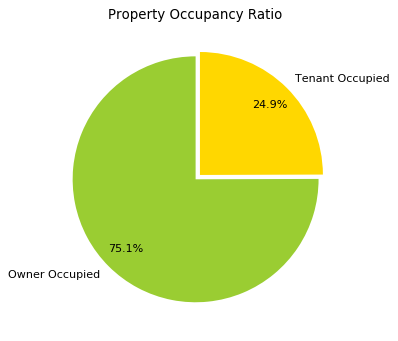

In [11]:
#Draw pie-chart
data = [1926215, 640326]
labels = ["Owner Occupied","Tenant Occupied"]
colors = ['yellowgreen','gold']

#explsion
explode = (0,0.05)
plt.figure(figsize=(5,5), dpi=80)

plt.pie(data, colors = colors, labels=labels, autopct='%1.1f%%',startangle=90, pctdistance=.8, explode = explode)

plt.title("Property Occupancy Ratio")

#Save fig
plt.savefig(output_path_figs+"\propertyoccupancy.png")

#Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

### Cime Type Analysis:

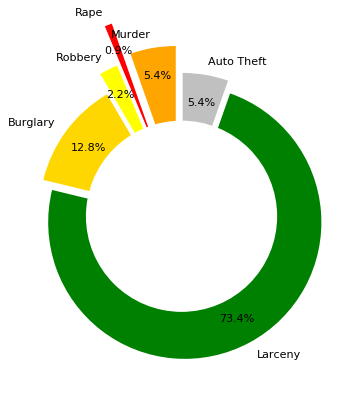

In [956]:
#Draw pie-chart
data = [murder_count,rape_count,robbery_count,burglary_count,larceny_count,murder_count]
labels = ["Murder","Rape","Robbery","Burglary","Larceny","Auto Theft"]
colors = ['Orange','Red','yellow',"gold","Green","Silver"]

#explsion
explode = (0.25,0.5,0.2,0.05,0.05,0.05)
plt.figure(figsize=(5,5), dpi=80)

plt.pie(data, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=.8, explode = explode)

#Draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')        
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.savefig(output_path_figs+"\crimeTypes.png")

#Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

In [957]:
#For google Map, we need Lat and long
lat=[]
lng=[]
def populateLatLng():
    #Update Latitude and Ligitude
    for key,row in summary_data.iterrows():
        try:
            ilat =row["Location"].split(",")[0]
            ilang=row["Location"].split(",")[1]
        except:
            ilat =40.0757384
            ilang=-74.4041622
        
        lat.append(ilat)
        lng.append(ilang)

In [958]:
#Populate Lat and Lang 
populateLatLng()
summary_data['Latitude'] = lat
summary_data['Longitude'] = lng

In [960]:
#Add Lat and Long to data set
summary_data['Latitude'] = summary_data['Latitude'].astype(float)
summary_data['Longitude'] =summary_data['Longitude'].astype(float)
summary_data['Serious Crimes'] =summary_data['Serious Crimes'].astype(float)

In [962]:
#Confirm results
summary_data.head(2)

,County,Municipality,Location,Property Count,Mean Property Tax,Median Property Tax,Mean Market Value,Median Market Value,Serious Crimes,Auto Theft,Larceny,Total,Population,Avg. Income,2018 Avg Score,2019 Avg Score,School Count,Latitude,Longitude
0,MONMOUTH,ABERDEEN TWP,"40.436522, -74.234672",6335,7995.348783,8250.99,332777.470735,343417.611639,119.4,65.3,789.0,973.7,2573.0,47906.0,51.849535,63.89889,2.0,40.436522,-74.234672
1,ATLANTIC,ABSECON CITY,"39.471343, -74.447517",3278,5580.447108,5573.36,180412.307634,180183.185937,351.3,60.6,2132.9,2544.8,34958.0,51397.0,41.017145,39.10780,2.0,39.471343,-74.447517


# Best places to live
* Conditions:
* serious crimes < 150 (per year per 10K people)
* school ranking > 70%
* property tax < 7K
* median house price < 400K
* avg icome > 40K

In [979]:
#Criteria to select best towns to raise family
crime_ = summary_data["Serious Crimes"]<150
school_ = summary_data["2018 Avg Score"]>70
tax_ = summary_data["Median Property Tax"]<7000
price_ = summary_data["Median Market Value"]<400000
income_ = summary_data["Avg. Income"]>40000

In [992]:
#Get results
best_places = summary_data[crime_ & school_ & tax_ & price_ &  income_]

In [985]:
#Locations - use Lat and Lng
locations = summary_data[["Latitude", "Longitude"]] 

#Use Humidity as weight
weights =summary_data["Serious Crimes"]

In [986]:
#Config map size
map_size = {
    'width': '600px',
    'height': '700px',
    'border': '2px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}

#Use zoom_level of 2 and a center point so the map displays properly
fig = gmaps.figure(layout=map_size,zoom_level=8,center=(39.75,-74.87))

#Create heat layer 
heatmap_layer = gmaps.heatmap_layer(locations, weights=weights,
                                    dissipating=False,
                                    max_intensity=2,
                                    point_radius=0.015)
#Add layer
fig.add_layer(heatmap_layer)

#Display figure
fig

Figure(layout=FigureLayout(border='2px solid black', height='700px', margin='0 auto 0 auto', padding='1px', wi…

### Best Places to live in NJ

In [993]:
# #Lets format columns
best_places['Median Property Tax']=best_places['Median Property Tax'].map('${:,.2f}'.format)
best_places['Median Market Value']=best_places['Median Market Value'].map('${:,.2f}'.format)
best_places['Population']=best_places['Population'].map("{:,}".format)
best_places['Avg Income']=best_places['Avg. Income'].map('${:,.2f}'.format)
best_places['2018 Avg Score']=best_places['2018 Avg Score'].map('{:,.2f}'.format)

C:\Users\anuaj\Anaconda3\envs\PythonData2020_1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\anuaj\Anaconda3\envs\PythonData2020_1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\anuaj\Anaconda3\envs\PythonData2020_1\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [1010]:
# Using the template add the town marks to the heatmap
info_box_template = """
<dl>
<dt>City</dt><dd>{Municipality}</dd>
<dt>County</dt><dd>{County}</dd>
<dt>Median Property Tax</dt><dd>{Median Property Tax}</dd>
<dt>Median Market Value</dt><dd>{Median Market Value}</dd>
<dt>Serious Crimes Rate (Per 10K)</dt><dd>{Serious Crimes}</dd>
<dt>Avg. School Score</dt><dd>{2018 Avg Score}</dd>
<dt>Avg. Income</dt><dd>{Avg Income}</dd>
<dt>Population</dt><dd>{Population}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
best_places_info = [info_box_template.format(**row) for index, row in best_places.iterrows()]
locations = best_places[["Latitude", "Longitude"]] 

In [1011]:
# Add marker layer ontop of heat map
map_size = {
    'width': '700px',
    'height': '650px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=map_size,zoom_level=8,center=(39.75,-74.87))

# Create city symbol layer
best_places_layer = gmaps.marker_layer(
    locations,info_box_content=[info_box_template.format(**row) for index, row in best_places.iterrows()]
)

# Add layer
fig.add_layer(heatmap_layer)
fig.add_layer(best_places_layer)

# Display figure
fig

Figure(layout=FigureLayout(border='1px solid black', height='650px', margin='0 auto 0 auto', padding='1px', wi…

In [ ]:
#Note: Other Summary reports are generated in individual note books of each data point